# VENV

In [ ]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.data import Dataset
from tensorflow.keras.layers import Dense, Dropout, Embedding, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D

# Data

In [ ]:
!curl -s -o flower.jpeg https://images.unsplash.com/photo-1604085572504-a392ddf0d86a?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=224&q=224

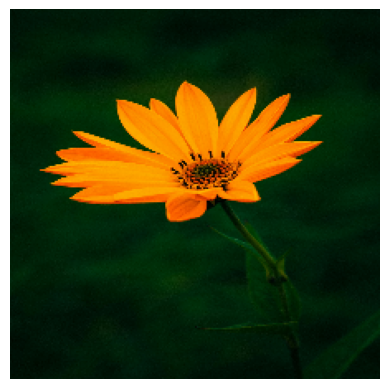

In [ ]:
image = plt.imread('flower.jpeg')
image = tf.image.resize(tf.convert_to_tensor(image), size=(224, 224))
plt.imshow(image.numpy().astype("uint8"))
plt.axis("off");

(16, 32, 32, 3)
(16, 1)


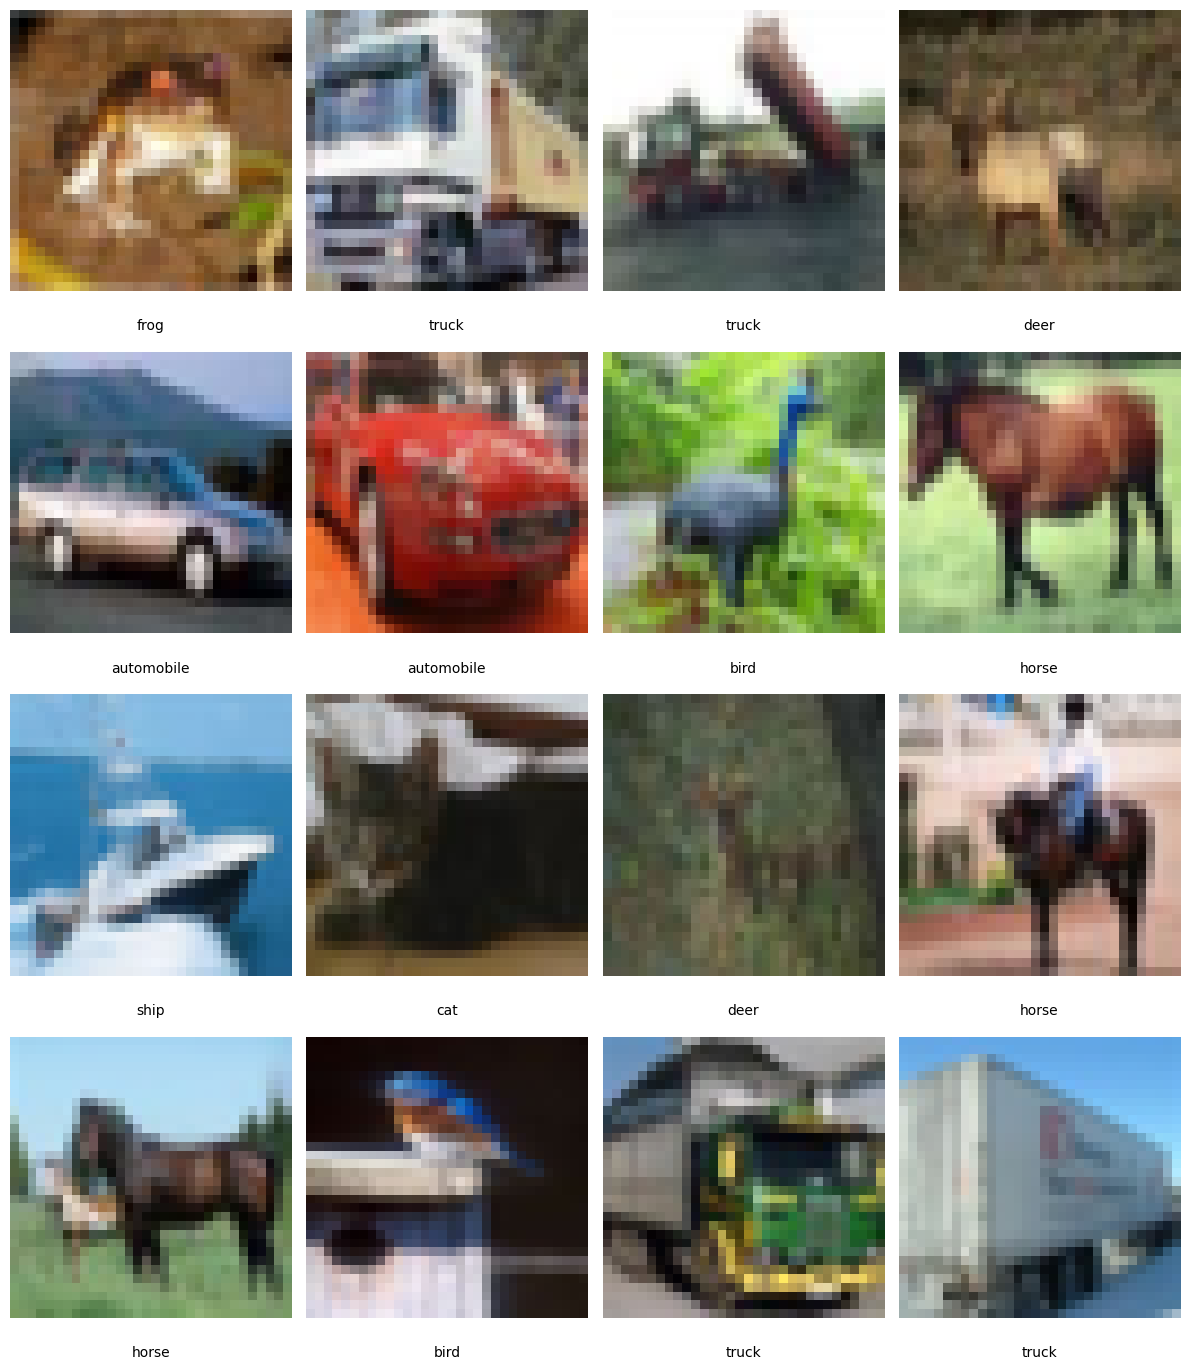

In [ ]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

label_dict = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck"
}

train_dataset = Dataset.from_tensor_slices((X_train, y_train)).batch(16)

for x, y in train_dataset:

    print(x.shape)
    print(y.shape)
    fig, axes = plt.subplots(4, 4, figsize=(12,14))
    for i, img in enumerate(x):
        ax = axes[i // 4, i % 4]
        img = tf.reshape(img, (32,32,3))
        ax.imshow(img.numpy().astype('uint8'))
        ax.axis('off')
        label = f'{label_dict[y[i].numpy().item()]}'
        ax.text(0.5, -0.1, label, ha='center', va='top', fontsize=10, transform=ax.transAxes)

    plt.tight_layout()
    plt.show()
    break

In [ ]:
from sklearn.model_selection import train_test_split

def augmentation(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.flip_left_right(image)
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = (image / 255.0)

    return image, label

def prepare_ds(ds,batch_size=32, BUFFER_SIZE=2000):
    return (ds.shuffle(BUFFER_SIZE)
      .batch(batch_size,drop_remainder=True)
      .map(augmentation, tf.data.AUTOTUNE)
      .prefetch(buffer_size=tf.data.AUTOTUNE))

def create_dataset(keep=1.0, train_size=0.8, batch_size=32):
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
    if keep!=1.0:
        X_train, _, y_train, _ = train_test_split(X_train, y_train, train_size=train_size)

    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=train_size)

    train_dataset = prepare_ds(Dataset.from_tensor_slices((X_train, y_train)), batch_size)
    val_dataset = prepare_ds(Dataset.from_tensor_slices((X_val, y_val)), batch_size)
    test_dataset = prepare_ds(Dataset.from_tensor_slices((X_test, y_test)), batch_size)

    return train_dataset, val_dataset, test_dataset


train_dataset, val_dataset, test_dataset=create_dataset(0.5, 0.8, 32)

In [ ]:
print(train_dataset.cardinality())
print(val_dataset.cardinality())
print(test_dataset.cardinality())


tf.Tensor(1000, shape=(), dtype=int64)
tf.Tensor(250, shape=(), dtype=int64)
tf.Tensor(312, shape=(), dtype=int64)


In [ ]:
# next(iter(train_dataset))[0].shape
for i,batch in enumerate(train_dataset):
    # print(i)
    print(batch[0].shape)
    print(batch[1].shape)

    break

(32, 32, 32, 3)
(32, 1)


# Architecture

In [ ]:
def dot_product_attn(q,k,v):
    d = tf.cast(tf.shape(q,)[-1], tf.float32)
    tf.transpose(k, perm= [0,1,3,2])
    attn_weight = tf.nn.softmax(tf.matmul(q,tf.transpose(k, perm= [0,1,3,2]))/d)
    attn_score = tf.matmul(attn_weight,v)

    return attn_score

x = tf.ones([8,4,24,16])
dot_product_attn(x,x,x).shape

TensorShape([8, 4, 24, 16])

In [ ]:
class MultiheadAttn(tf.keras.layers.Layer):
    def __init__(self, num_heads, emb_dim, drop_rate=0.1):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = emb_dim//num_heads
        self.q_proj = Dense(emb_dim)
        self.k_proj = Dense(emb_dim)
        self.v_proj = Dense(emb_dim)
        self.o_proj = Dense(emb_dim)
        self.dropout = Dropout(rate=drop_rate)

    @staticmethod
    @tf.function
    def dot_product_attn(q,k,v):
        d = tf.cast(tf.shape(q,)[-1], tf.float32)
        tf.transpose(k, perm= [0,1,3,2])
        attn_weight = tf.nn.softmax(tf.matmul(q,tf.transpose(k, perm= [0,1,3,2]))/d)
        attn_score = tf.matmul(attn_weight,v)

        return attn_score

    def call(self,x):
        shape = tf.shape(x)
        batch_size = shape[0]
        seq_len = shape[1]
        emb_dim = shape[2]

        q = tf.transpose(tf.reshape(self.q_proj(x), [batch_size, seq_len, self.num_heads, self.head_dim]), perm=[0,2,1,3])
        k = tf.transpose(tf.reshape(self.k_proj(x), [batch_size, seq_len, self.num_heads, self.head_dim]), perm=[0,2,1,3])
        v = tf.transpose(tf.reshape(self.v_proj(x), [batch_size, seq_len, self.num_heads, self.head_dim]), perm=[0,2,1,3])

        score = dot_product_attn(q,k,v)
        o = tf.reshape(tf.transpose(score, perm=[0,2,1,3]), [batch_size, seq_len, emb_dim])
        o = self.o_proj(o)
        o = self.dropout(o)

        return o

x = tf.ones([8,24,16])
tmp = MultiheadAttn(4, 16, 0.2)
tmp(x).shape

TensorShape([8, 24, 16])

In [ ]:
class PatchExtractor(tf.keras.layers.Layer):
    def __init__(self):
        super(PatchExtractor,self).__init__()

    def call(self, x):
        batch_size = tf.shape(x)[0]
        patches = tf.image.extract_patches(
            images = x,
            sizes = [1, 16, 16, 1],
            strides = [1, 16, 16, 1],
            rates = [1, 1, 1, 1],
            padding = 'VALID'
        )
        patch_dims = tf.shape(patches)[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])

        return patches

In [ ]:
batch = tf.ones([1,32,32,3])
# batch = tf.expand_dims(image, axis=0)
patches = PatchExtractor()(batch)
patches.shape

TensorShape([1, 4, 768])

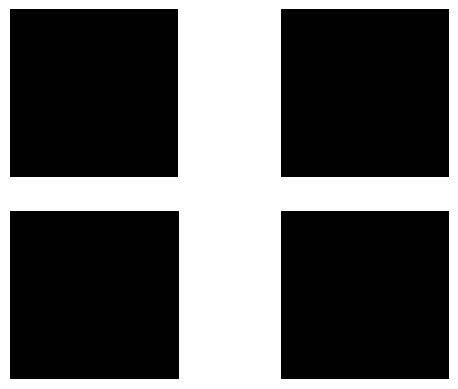

In [ ]:
n = int(np.sqrt(patches.shape[1]))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i+1)
    patch = tf.reshape(patch, (16,16,3))
    ax.imshow(patch.numpy().astype('uint8'))
    ax.axis('off')

In [ ]:
class PatchEncoder(tf.keras.layers.Layer):
    def __init__(self, num_patches, emb_dim):
        super().__init__()
        self.num_patches = num_patches
        self.emb_dim = emb_dim
        w_init = tf.random_normal_initializer()
        self.cls_token = w_init(shape=(1, emb_dim), dtype= 'float32')
        self.projection = Dense(units=self.emb_dim)
        self.positional_embedding = Embedding(input_dim = num_patches+1, output_dim = emb_dim)

    def call(self, x):
        batch_size = tf.shape(x)[0]

        cls_token = tf.tile(self.cls_token, multiples = [batch_size, 1])
        cls_token = tf.reshape(cls_token, (batch_size, 1, self.emb_dim))

        patch_emb = self.projection(x)
        patch_emb = tf.concat([cls_token,patch_emb], 1)

        position = tf.range(start=0, limit=self.num_patches+1, delta = 1)
        position_emb = self.positional_embedding(position)

        embedding = patch_emb + position_emb

        return embedding

tmp = PatchEncoder(4, 768)
embedding = tmp(patches)
embedding.shape

TensorShape([1, 5, 768])

In [ ]:
class MLP(tf.keras.layers.Layer):
    def __init__(self, hidden_dim, output_dim, drop_rate = 0.1):
        super().__init__()
        self.ff1 = Dense(hidden_dim, activation = 'gelu')
        self.ff2 = Dense(output_dim)
        self.dropout = Dropout(drop_rate)

    def call(self, x):
        x = self.ff1(x)
        x = self.dropout(x)

        x = self.ff2(x)
        out = self.dropout(x)

        return out

x = tf.ones([1,197,768])
tmp = MLP(768*2,768)
out=tmp(x)
out.shape

TensorShape([1, 197, 768])

In [ ]:
class EncoderBlock(tf.keras.layers.Layer):
    def __init__(self, emb_dim, num_heads, drop_rate):
        super().__init__()
        self.norm1 = LayerNormalization(epsilon=1e-6)
        self.attn = MultiheadAttn(num_heads=num_heads, emb_dim = emb_dim, drop_rate = drop_rate)
        self.norm2 =LayerNormalization(epsilon=1e-6)
        self.mlp = MLP(emb_dim*2, emb_dim, drop_rate)

    def call(self, x):
        x = self.norm1(x)
        x1 = self.attn(x)
        x = x + x1

        x = self.norm2(x)
        x1 = self.mlp(x)
        x = x + x1

        return x

x=tf.ones([1,4, 768])
tmp=EncoderBlock(768, 4, 0.2)
out=tmp(x)
out.shape

TensorShape([1, 4, 768])

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, emb_dim, num_blocks, num_heads, drop_rate=0.2):
        super().__init__()
        self.blocks = [EncoderBlock(emb_dim, num_heads, drop_rate) for _ in range(num_blocks)]
        self.norm = LayerNormalization(epsilon=1e-6)
        self.dropout = Dropout(drop_rate)

    def call(self, x):
        for block in self.blocks:
            x = block(x)
        x=self.norm(x)
        x=self.dropout(x)

        return x

x= tf.ones([1, 4, 768])
tmp = EncoderLayer(768, 2, 4)
out = tmp(x)
out.shape

TensorShape([1, 4, 768])

In [ ]:
class VisionTransformer(tf.keras.Model):
    def __init__(self, num_patch, emb_dim, num_blocks, num_heads,num_classes, drop_rate=0.2):
        super().__init__()
        self.patch_extractor = PatchExtractor()
        self.patch_encoder = PatchEncoder(num_patch,emb_dim)
        self.Encoder = EncoderLayer(emb_dim,num_blocks, num_heads, drop_rate)
        self.head = Dense(num_classes)

    def call(self,x):
        x = self.patch_extractor(x)
        x = self.patch_encoder(x)
        x = self.Encoder(x)
        x = self.head(x[:,0,:])

        return x

x= tf.ones([1, 32, 32, 3])
tmp = VisionTransformer(4, 768, 2, 4, 3)
out = tmp(x)
out.shape

TensorShape([1, 3])

In [ ]:
tmp.summary()

Model: "vision_transformer_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ patch_extractor_17 (PatchExtractor)  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ patch_encoder_17 (PatchEncoder)      │ ?                           │         594,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_layer_17 (EncoderLayer)      │ ?                           │       9,455,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_15          │ (1, 768)                    │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_429 (Dense)                    │ (1, 3)                      │           2,307 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,052,355 (38.35 MB)

 Trainable params: 10,052,355 (38.35 MB)

 Non-trainable params: 0 (0.00 B)

# Training

In [ ]:
model = VisionTransformer(4, 768, 2, 4, 10)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
train_dataset, val_dataset, test_dataset=create_dataset(0.5, 0.8, 32)

In [ ]:
EPOCHS=1

model.fit(train_dataset,
          epochs=EPOCHS,
          validation_data=val_dataset)

# attention map return at model
# interprete fucntion
# num eval_step
# scratch_patch

  18/1000 ━━━━━━━━━━━━━━━━━━━━ 33:40 2s/step - accuracy: 0.0998 - loss: 7.2368

KeyboardInterrupt: 

In [ ]:
# resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
# tf.config.experimental_connect_to_cluster(resolver)
# # This is the TPU initialization code that has to be at the beginning.
# tf.tpu.experimental.initialize_tpu_system(resolver)
# print("All devices: ", tf.config.list_logical_devices('TPU'))
# strategy = tf.distribute.TPUStrategy(resolver)

In [ ]:
from fastprogress import master_bar, progress_bar
from types import SimpleNamespace

class Trainer:
    def __init__(self, model_tpye, model_config, training_config):
        self.train_dataset, self.val_dataset, self.test_dataset = create_dataset(training_config.batch_size)

        if len(tf.config.list_physical_devices('GPU')) > 1:
            self.strategy = tf.distribute.MirroredStrategy()
        elif len(tf.config.list_physical_devices('GPU')) == 1:
            self.strategy = tf.distribute.OneDeviceStrategy("GPU:0")
        else:
            self.strategy = tf.distribute.get_strategy()

        self.training_config=training_config
        self.cls = 0
        with self.strategy.scope():
            self.model = model_tpye(**model_config)
            self.optimizer = tf.keras.optimizers.Adam(learning_rate = training_config.learning_rate)
            self.loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction = tf.keras.losses.Reduction.NONE)
            self.train_dist_dataset = self.strategy.experimental_distribute_dataset(self.train_dataset)
            self.val_dist_dataset = self.strategy.experimental_distribute_dataset(self.val_dataset)
            self.test_dist_dataset = self.strategy.experimental_distribute_dataset(self.test_dataset)

    def save_checkpoint(self):
        self.model.save_weights(self.training_config.ckpt_path)

    def train(self):
        def forward(X, y, training=False):
            logits = self.model(X, training=training)

            loss = self.loss_fn(y, logits)
            loss = tf.reduce_sum(loss) * (1.0/self.training_config.batch_size)

            return loss, logits

        @tf.function
        def train_step(dist_inputs):
            def step_fn(inputs):
                X, y = inputs
                with tf.GradientTape() as tape:
                    loss, logits = forward(X, y, training=True)
                    y_pred = tf.argmax(logits, axis=-1)
                    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.cast(y_pred, tf.int64), tf.cast(y, tf.int64)), tf.float32))

                grads = tape.gradient(loss, self.model.trainable_variables)
                self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

                return loss, accuracy

            return _compute_metrics(step_fn, dist_inputs)

        @tf.function
        def val_step(dist_inputs):
            def step_fn(inputs):
                X, y = inputs
                loss, logits = forward(X, y, training=False)
                y_pred = tf.argmax(logits, axis=-1)
                accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.cast(y_pred, tf.int64), tf.cast(y, tf.int64)), tf.float32))

                return loss, accuracy

            return _compute_metrics(step_fn, dist_inputs)

        @tf.function
        def _compute_metrics(step_fn, dist_inputs):
            per_replica_loss, per_replica_accuracy = self.strategy.run(step_fn, args=(dist_inputs,))

            total_loss = self.strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
            total_accuracy = self.strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_accuracy, axis=None)

            mean_loss = total_loss / tf.cast(self.training_config.batch_size, tf.float32)
            mean_accuracy = total_accuracy / tf.cast(self.training_config.batch_size, tf.float32)


            return mean_loss, mean_accuracy

        with self.strategy.scope():
            num_train_step = tf.data.experimental.cardinality(self.train_dist_dataset).numpy()
            num_val_step = tf.data.experimental.cardinality(self.val_dist_dataset).numpy()

            for epoch in range(self.training_config.num_epochs):
                print(f'Epoch {epoch+1}/{self.training_config.num_epochs}')
                pbar = tf.keras.utils.Progbar(target=int(num_train_step), stateful_metrics=['loss', 'accuracy'])
                metrics = {}

                for step, batch in enumerate(self.train_dist_dataset):
                    loss, accuracy = train_step(batch)
                    self.cls += tf.reduce_sum(tf.cast(batch[1]>=0, tf.float32)).numpy()

                    metrics.update({'loss': loss.numpy(),
                                    'accuracy': accuracy.numpy()})
                    pbar.update(step+1, values=metrics.items(), finalize=False)

                for batch in self.val_dist_dataset:
                    loss, accuracy = val_step(batch)
                    metrics.update({'val_loss': loss.numpy(),
                                    'val_accuracy': accuracy.numpy()})

                pbar.update(num_train_step, values=metrics.items(), finalize=True)

            self. save_checkpoint()

    def interprete(self):


model_config = dict(
    num_patch = 4,
    emb_dim = 16,
    num_blocks = 4,
    num_heads=4,
    num_classes = 10,
    drop_rate=0.2
)
training_config = SimpleNamespace(
    num_epochs = 20,
    batch_size= 512,
    learning_rate = 1e-3,
    ckpt_path= '/content/ViT.weights.h5'
)

trainer = Trainer(VisionTransformer, model_config, training_config)
trainer.train()

Epoch 1/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 34s 18ms/step - loss: 2.4453e-04 - accuracy: 1.7357e-04 - val_loss: 2.7234e-04 - val_accuracy: 1.3924e-04
Epoch 2/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - loss: 2.6290e-04 - accuracy: 1.8501e-04 - val_loss: 2.4165e-04 - val_accuracy: 2.1744e-04
Epoch 3/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - loss: 2.0974e-04 - accuracy: 1.8692e-04 - val_loss: 2.0999e-04 - val_accuracy: 2.0218e-04
Epoch 4/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 2.5593e-04 - accuracy: 2.3842e-04 - val_loss: 2.3049e-04 - val_accuracy: 2.3460e-04
Epoch 5/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - loss: 2.6497e-04 - accuracy: 1.6975e-04 - val_loss: 2.3131e-04 - val_accuracy: 2.2316e-04
Epoch 6/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - loss: 2.2564e-04 - accuracy: 1.7738e-04 - val_loss: 2.0222e-04 - val_accuracy: 1.7929e-04
Epoch 7/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - loss: 2.3037e-04 - accuracy: 2.1935e-04 - val_loss: 2.